## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SIMClassifier

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

```python
from pysim import SIMClassifier
clf = SIMClassifier(method="first_order", spline="a_spline", reg_lambda=0.1, reg_gamma=0.1, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Usage**

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- spline: The type of spline method. default="a_spline"

        "p_spline": p-spline (from pygam package)
    
        "p_spline_mono": p-spline with monotonic constraint (from pygam package)
    
        "a_spline": adaptive spline where knots are automatically selected (see Goepp, V., Bouaziz, O. and Nuel, G., 2018. Spline regression with automatic knot selection. arXiv preprint arXiv:1808.01770.)

- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=0.1, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [3]:
# import scipy
# import numpy as np
# import pandas as pd 
# from scipy.linalg import cholesky
# from matplotlib import pyplot as plt

# from sklearn.utils.validation import check_is_fitted
# from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
# from patsy import dmatrix, build_design_matrices

# clf = SIMClassifier(degree=2, knot_num=20, spline="a_spline", random_state=0)
# x, y = clf._validate_input(x, y)
# n_samples, n_features = x.shape
# sample_weight = np.ones(n_samples) / n_samples

# if clf.method == "first_order":
#     clf.beta_ = clf._first_order(x, y, sample_weight)
# elif clf.method == "first_order_thres":
#     clf.beta_ = clf._first_order_thres(x, y, sample_weight)
# elif clf.method == "second_order":
#     clf.beta_ = clf._second_order(x, y, sample_weight)

# if len(clf.beta_[np.abs(clf.beta_) > 0]) > 0:
#     if (clf.beta_[np.abs(clf.beta_) > 0][0] < 0):
#         clf.beta_ = - clf.beta_
# xb = np.dot(x, clf.beta_)

# def diff_matrix(order, knot_num):
#     results = [] # a container to collect the rows
#     n_rows = order + 2
#     for _ in range(n_rows): 
#         row = [1] # a starter 1 in the row
#         if results: # then we're in the second row or beyond
#             last_row = results[-1] # reference the previous row
#             row.extend([sum(pair) for pair in zip(last_row, last_row[1:])])
#             row.append(1)
#         results.append(row) # add the row to the results.

#     diss_operator = [] # a container to collect the rows
#     for i, item in enumerate(np.array(row)):
#         diss_operator.append(item * (-1) ** i)
#     diss_operator.reverse()
#     D = np.zeros((knot_num, knot_num + order + 1), dtype=np.float32)
#     for i in range(knot_num):
#         D[i,i:(i+order+2)] = diss_operator
#     return D

# def link(x):
#     with np.errstate(divide='ignore', over='ignore'):
#         return 1 / (1 + np.exp(-x))

# def inv_link(x):
#     with np.errstate(divide='ignore', over='ignore'):
#         return np.log(x) - np.log(1 - x)

# def get_loss(label, pred):
#     return - np.mean(label * np.log(pred) + (1 - label) * np.log(1 - pred))

# x = xb
# y = y
# sample_weight = np.ones(n_samples)

# knots = list(np.linspace(x.min(), x.max(), clf.knot_num + 2, dtype=np.float32)[1:-1])
# xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1",
#                {"x": [x.min(), x.max()], "knots": knots, "degree": clf.degree})
# init_basis = np.asarray(build_design_matrices([xphi.design_info],
#                   {"x": x, "knots": knots, "degree": clf.degree})[0])
# D = diff_matrix(clf.degree, clf.knot_num)
# w = np.ones([clf.knot_num], dtype=np.float32) 
# W = np.diag(w)

# tempy = y.copy()
# tempy[tempy==0] = 0.01
# tempy[tempy==1] = 0.99
# BWB = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), init_basis, axes=([0], [0]))
# BWY = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), inv_link(tempy), axes=([0], [0]))
# update_a = np.dot(np.linalg.pinv(BWB + clf.reg_gamma * D.T.dot(W).dot(D)), BWY)
# best_loss = get_loss(y, link(np.dot(init_basis, update_a)))
# for i in range(10):
#     best_loss_irls = best_loss
#     for j in range(10):
#         lp = np.dot(init_basis, update_a)
#         mu = link(lp)
#         omega = mu * (1 - mu)
#         mask = (np.abs(omega) >= 10 ** (-5)) * np.isfinite(omega)
#         mask = mask.ravel()
#         if np.sum(mask) == 0:
#             break

#         BW = init_basis[mask, :] * sample_weight[mask].reshape([-1, 1])
#         BWOB = np.tensordot(BW * omega[mask].reshape([-1, 1]), init_basis[mask, :], axes=([0], [0]))
#         update_a_temp = np.dot(np.linalg.pinv(BWOB + clf.reg_gamma * D.T.dot(W).dot(D)),
#                         BWOB.dot(update_a) + np.tensordot(BW, y[mask] - mu[mask], axes=([0], [0])))
#         new_loss = get_loss(y, link(np.dot(init_basis, update_a_temp)))
#         if new_loss - best_loss_irls >= 0:
#             break
#         best_loss_irls = new_loss
#         update_a = update_a_temp

#     if best_loss_irls - best_loss >= 0:
#         break
#     best_loss = best_loss_irls
#     update_w = 1 / (np.dot(D, update_a) ** 2 + 0.00001 ** 2)
#     W = np.diag(update_w.reshape([-1]))



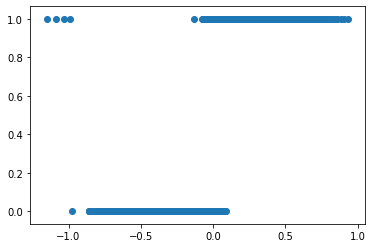

In [4]:
plt.scatter(np.dot(x, beta), y)

The best hyperparameter combination can be selected via cross-validation

In [5]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIMClassifier(degree=2, knot_num=10, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:   18.6s remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   24.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.4s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 2.45 s, sys: 7.41 s, total: 9.86 s
Wall time: 24.7 s


In [6]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 0.1, 'reg_lambda': 0.05}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [7]:
clf = grid.best_estimator_
clf

SIMClassifier(degree=2, knot_num=10, method='first_order', random_state=0,
              reg_gamma=0.1, reg_lambda=0.05, spline='a_spline')

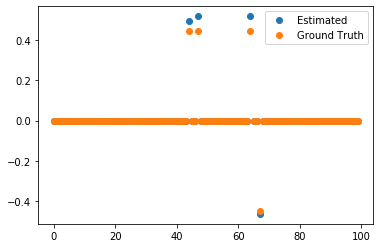

In [8]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

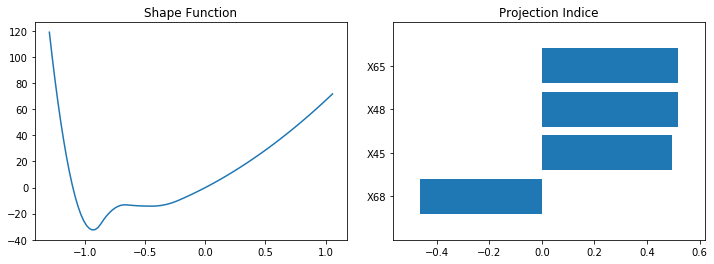

In [9]:
grid.best_estimator_.visualize()

In [10]:
roc_auc_score(y, 1 / (1 + np.exp(- grid.predict(x))))

0.9638010772921258

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [11]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

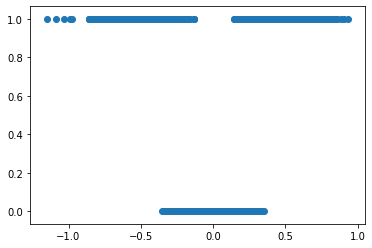

In [12]:
plt.scatter(np.dot(x, beta), y)

In [13]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIMClassifier(degree=2, knot_num=10, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:    9.3s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   15.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.5s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 2.53 s, sys: 6.54 s, total: 9.07 s
Wall time: 16.8 s


In [14]:
grid.best_params_

{'method': 'second_order', 'reg_gamma': 1.0, 'reg_lambda': 0.05}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [15]:
clf = grid.best_estimator_
clf

SIMClassifier(degree=2, knot_num=10, method='second_order', random_state=0,
              reg_gamma=1.0, reg_lambda=0.05, spline='a_spline')

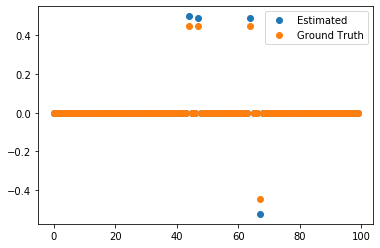

In [16]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

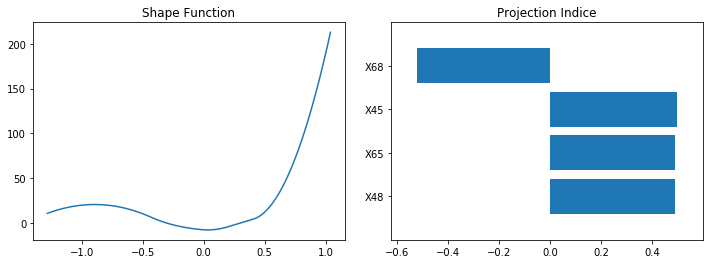

In [17]:
grid.best_estimator_.visualize()

In [18]:
roc_auc_score(y, 1 / (1 + np.exp(- grid.predict(x))))

0.9336031088958352

In [29]:
estimator_error = np.average((grid.predict(x) != y), axis=0)
estimator_weight  = np.log((1 - estimator_error) / estimator_error)
estimator_error

0.0565

In [37]:
getattr(grid, 'classes_', None)
np.log(0.1) - (np.log(0.9) + np.log(0.1)) / 2

-1.0986122886681096

In [23]:
from scipy.special import xlogy
classes = [0, 1]
y_codes = np.array([-1. / (2 - 1), 1.])
y_coding = y_codes.take(classes == y[:, np.newaxis])
xlogy(y_coding, grid.predict_proba(x)).sum(axis=1)

array([0., 0., 0., ..., 0., 0., 0.])

In [49]:
sample_weight = 1 / np.ones(x.shape[0])
with np.errstate(divide='ignore', over='ignore'):
    sample_weight = sample_weight * np.exp(-0.5 * np.sum(y_coding * np.log(np.hstack([1 - grid.predict_proba(x), grid.predict_proba(x)])), axis=1))

In [50]:
sample_weight

array([0.02457595, 0.03117026, 0.02228674, ..., 0.12379124, 0.        ,
       0.36025444])

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from pysim import SIMClassifier
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = AdaBoostClassifier(base_estimator=SIMClassifier(spline='a_spline'), n_estimators=100, random_state=0)
clf.fit(X, y)


UnboundLocalError: local variable 'update_w' referenced before assignment